# Create summary tables that address relevant factors related to COVID-19

# Background


Scientists and researchers often have large amount of data to sieve through to help them identify papers, document and articles relevant to their research. This results in time that could have been spent more productively otherwise. In emergency situations such as Covid, it becomes even more critical to ensure research activities can be carried out effectively in a shorter span of time. There is a clear need to have the right technology to help researchers carry out their daily activitites effectively.

# Solution Design

![High Level Solution Design](https://storage.googleapis.com/kagglesdsdata/datasets%2F704715%2F1251574%2Fcord19.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1592462011&Signature=e3%2BkNAWiP80slxfluUEoDRuqhc6UDZzoDzZzH4j7ylekOOXlZ2%2BzbjzFF56uvgTNyF5UTXK1lRlA6m7S9FYmcBB9wvStF3b8ws347juX%2FBrOrQTthwotaaKANb8CN6yvP%2Fd3KcBgx5UsdL6FN1cHMiO%2F8aFXbidtt8ILy2mC88UYkwXNCyTbf6pIx8qmPBvoE3N3yWmdb2dfJAkSBjmrqDUpcc0oIFoLjddOfAixAqLI5BahR%2BgkzepY4UdD8HHWywOQZXrd92yYrtRbFFN8epUmyhd5AysmdDTFVoDjwTsWYHgjKB80txFhsJBToyx7kqGmBduJIb4BO%2BStQSQYoQ%3D%3D)
Though the solution implemented is for relevant factors related to Covid-19, it's designed to ensure it can be extended to address other questions or tasks pertaining to Covid-19. Some of the design principles we have followed are:

1. Modularity

  As part of the design, there's a clear demarcation between the capabilities of each functional blocks. Each cell in the notebook would correspond to a different python file or module and can be used for other use cases. 
   
   
2. Extensibility

Modularity by design paves way for the solution being extensible and thereby provides the capability to cater to other potential use cases or tasks. We've used a config driven approach to ensure workflows are generic and therefore extensible by design.


3. Distributed Processing

By design the solution caters to code being processed in a distributed manner using Python's multiprocessing(mp) library. The modularity of the code is such that if we were to use a cluster, one could substitute mp with a more suitable library such as dask.
    
    
# Implementation Details


We propose a four step approach in generating summary table for the sub tasks.  

## 1. Identify relevant files

There are numerous options to filter our relevant files for further analysis. Linguistic approach will help us narrow down to a list but is computationally expensive and so is using a regular exprrssion based approach. We instead rely on Flashtext which is high performant and based off [Aho Corasick's algorithm](https://en.wikipedia.org/wiki/Aho%E2%80%93Corasick_algorithm) and the efficient use of trie datastructure. Since we are not dependent on partial match Flashtext is an effective way of filtering out noise. 

## 2. Identify relevant excerpts

In order identify relevant documents, we use linguistic patterns such as phrases and grammatical patterns to reduce the search scope from the shortlisted files to the one's which are truly relevant. 

We use Python's multiprocessing library for distributed processing. At the heart of the solution is the use of Spacy's Token Matcher library as the pattern matching engine. The sub tasks are grouped based on similarity of patterns for different sub tasks 

## 3. Scoring, Ranking Excerpts and Extracting Factors

Each pattern represents a sub task or a group of similar sub tasks. The pattern is then used to identify excerpts from each paper. Typically, a pattern would result in more than on match i.e more than one excerpts would be surfaced. Each match or excerpt is scored. The score depends on which part of the paper the excerpt is found. Titles have the highest score followed by abstract and then body text and so on. The scores are configurable. 

A paper is then scored based on the cumulative scores of all the excerpts extraced from that paper. The final summary table would include relevant papers sorted based on the paper's score. We use the cumulative score for excerpts as a indicator of how relevant a paper is to the given pattern. 

Factors are key phrases which are essentially trigram Noun Phrases extracted from each excerpt. The number of factors indicate how informative the excerpt is. We use this a way to rank excerpts. 


## 4. Identify Study Types, Measure of Evidence and parameters from Metadata

### Study Types
The different study types was chosen based on references, titles and abstract from the research papers. We use a pre-trained model from [Scispacy](https://allenai.github.io/scispacy/) as the basis to identify which study type the papers are most similar to. We extract title, abstract and back matter from papers as the text against which a study type will be assigned. Since we also need descriptions of study type, we handcrafted the study type descriptions based on contents from Wikipedia. We then use Spacy's model trained on biomedical data with a large vocabulary and 50K vectors to get a cosine similarity score. Instead of obtaining top n study types, we instead define a threshold and get all study types which are strongly correlated with the text in the papers. 

### Measure of Evidence
We use Spacy's NER feature to extract entities which belong to GPE and DATE category and limit the entries upto 3 each. 


### Parameters from Metadata
The remainder of the columns in the summary table are obtained from the metadata file. The 'Influential' column for now defaults to Yes based on the hypothesis that the excerpts are matched against the different sub tasks and therefore influential. However, we are currently evaluating this hypothesis and is bound to change in the coming versions of this notebook.
Publish date, Cord UID, Study Link and DOI are obtained from the metadata file.

## Defining Patterns 

We use Spacy's [Rule Based Matching Engine ](https://spacy.io/usage/rule-based-matching) to define, manage and use patterns. More specifically, we use Token Matcher as it provides the flexibility to use both regular expression and linguistic patterns. 

### Methodology

For each subtask we developed at least one pattern for searching the dataset and identifying extracting excerpts using the approach outlined below. 

1.	Create an initial sentence structure based on the subtasks
     
    ![Structure](https://storage.googleapis.com/kagglesdsdata/datasets%2F704715%2F1254715%2Fstructure.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1592522686&Signature=TFVwoll8yyWK3eTywIyrE0BPWQuNPl8L0Ar1K7RR9bDVkHytQtbya7%2Bk6xdnxaM%2BZEOYEuiXFwyR7SfsSNw%2BP2or9cT9LIG5pbo3pKVxYlakT64CKYO6whtcdYYk6EfmFY4BslqTTqm2rkj6UP3NVq9PN0ygJn5nEjuguDraasOHMvQ1zaU7X%2BkOmd3w3Y3cS%2BA0cw0dILraUNikfhSTqSlHkN7EFlt1gOvHKz5Il8%2BOgt7HgaBaWwo%2BKmJxcKokZv%2BfI1eN%2FWL0%2B%2FKQGSTEUXFEIMMG2f0rhDX8tLVZKGHTdMWcaykMmvwqAoyOMk9sGXyc7hfMmDCuu5IpQJaX1Q%3D%3D)
    
2.	Generalise the sentences by including a wildcard character (*) in between to enable for flexibility between two key words

    ![pattern](https://storage.googleapis.com/kagglesdsdata/datasets%2F704715%2F1254715%2Fpattern.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1592522722&Signature=O%2FnGemCXhQpW7gS4A%2Fto9qd839DKev5OfRUO1JuDYy1YgkHOg4MZt%2F9wQm98EEsLIjBOk8DFYXdqpk4ibeqOx%2BEpaGElqrALoW%2FWKZjKBrqjCaNAtWp4Uav14J0XDd97wUSfPeheaSYxJpodYF%2BFdcgV%2F8QHNzWNHJN%2Bepgj%2FH93tu71oehk6LYL7o5vGbXl2%2Fo5mwDEs0qsHb%2BLE%2BmodLVFTOaVrYSsdPvy3IRFxJjPZBFyETagtSKRqH9jasADo5txYCogz2aKKFBnyIb80qExbQt1HoIUYnIFvOKhrVDcYNXD9XrbjSoQmd7jXFJCweZeb9C3V7StvFCfEQQ%2FQw%3D%3D)
    
  
3.	Extend on the key words specific to and across each subtask using a broad set of resources (synonym search such as wordnet, authoritative resources such as [Australian Government Department of Health](https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-advice-for-travellers#travel-within-australia) and [US Centers for Disease Control and Prevention (CDC)](https://www.cdc.gov/training/QuickLearns/epimode/secondary-spread.html), news articles found online, medical journals such as the LANCET, World Medical Association, Bulletin of the WHO, Cambridge University Press, New England Journal of Medicine etc.)

    > e.g. PPE mask, effective, helpful, control, manage, spread, outbreak
    
    
4.	Use REGEX and LEMMA to account for synonym conjugations

    > eg: Spread - spreading
    

# Interpreting Results

## Filtering files relevant to each subtask
The first step of filtering files to reduce the search scope from tens of thousands of files to a few hundreds. Based on the keywords idnetified the distribution of papers covering the topics (sub tasks) are shown in the figure below.

**Coverage of sub tasks across research papers based on a small sample set.** This break-up shown in the Figure may not be a complete representation of the entire dataset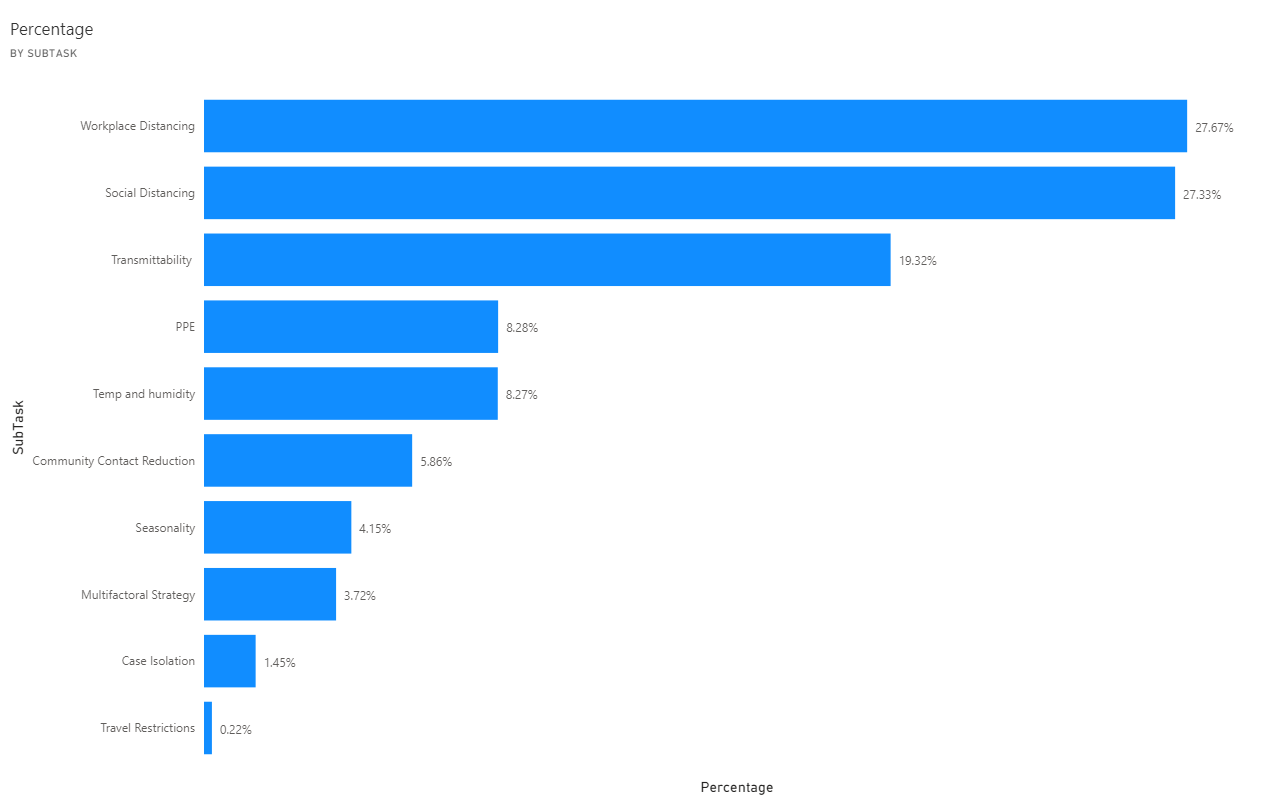

The results are obtained for each sub task to help researchers focus based on the task of interest. A sample summary table is shown in the figure below. The score is a proxy of how informative the paper is with respect to the sub task. Factors are derived from excerpts. For each subtask, we generate the table based off a very sample of the shortlisted papers to ensure completion of the entire flow and to be able to see results.

## Knowledge Graph

One of the ways one could consume the results is building a Knowledge Graph to undersand the relationships between factors, excerpts and papers. It would help researchers navigate through papers having strong tie strengths with other papers. An example of how this can be obtained is shown in the graphs below. 

In [ ]:
#refer to these files for the graph
import pandas as pd
df = pd.read_csv("../input/results/results_1592013931.804742.csv")
df[:5]

**Note** The graphs below have been generated based off results from an earlier run, partial results of the dataframe showb above. The same can be regenerated with the latest results.

The first view shows the entire diagram showing connections between the 'Study' column with their corresponding factors, which are comma separated under the 'factors' column. Each Study type is depicted by grey nodes, and all the factors are indicated by purple nodes.The study type nodes also vary in size and the sizes are determined by the values form the 'score' column.The score columns have been normalised using natural log for visualisation purpose.

![Ridiculogram](https://storage.googleapis.com/kagglesdsdata/datasets%2F704715%2F1251574%2Fridiculogram.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1592463654&Signature=meETaP77Qtk5Q%2BWgFgaihxjvVjd4fQJic8pW%2F%2FabA2mrOXccGxxk5aH3Oh1pMt%2Ff26ouFNP%2F%2B%2BhimLC7Ea5c9Lar1K7tnA8t5IHwTKhli89pPoCydxCnhcmuv5vqDumy%2Fa4WqtdZgDFAaMUr62gzstaC7oli0Zt8bUIYPYu9QE2CHrawvRR2fehE1E6C1xB44o0rB1AMMRCQBpLva%2FdNqan2ERmwK2R7xGDsliH%2F919F43ACsJrR8kjJdmVKzyT0bUpF2hrtp8u6GIIKh6dT1Kn4A8P7wx5GdnS0X1Q6ae%2BZlGSve%2BKUUZGnmn%2BXonTAspLa69PPV7AMUY4Z478V%2Bg%3D%3D)

This diagram is created using a combination of Fruchterman & Reingold (1991) and ForceAtlas2 methods. Study types that don't have many relevant factors are located at the periphery and the ones that have a lot of coresponding factors tend to be located at the centre of this diagram. These graphs are created using the software called Gephi(the graphml file has been uploaded in under the input folder of the Data pane).

![Annotation](https://storage.googleapis.com/kagglesdsdata/datasets%2F704715%2F1251574%2Fislands.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1592463677&Signature=jqe41eWPnXM9hctgFJg6fXgXx%2FdTSE0xE1eJkLI8jLCNHPPOT5fSUAPd4saxKAzfcMNrC3qQrQbprtkGSVD9LXsg%2BqmnUkOprLec6AnBjHwYAVo5Af4gwdxovTockhSKJNmUeIGHH98vebXFoBx59Ofeana0BOiXlL%2FD%2FOzd6AYcN7hLNOYXo3DmhLKcaTlS8ImC5ZtUhapaLx4tDkewlV5odTWM4YneuvFs2l9cx8FZ2os7QVE0d0AfnoxaqViS%2Bgn%2BZYG1dAHw2IKKsRDJnI46J6qYNwwk99Zp%2BYiHG8PQEsFI8Nmi60ChE%2BqSSn2fVwOlNDhiztOs55fmq8KMNg%3D%3D)

The second view shows the zoomed in views to a specific area of this graph. The third and last view shows that hovering over a specific study type and clicking it highlights that study type and its connected factors, while blurring the other nodes in this diagram.

![Islands](https://storage.googleapis.com/kagglesdsdata/datasets%2F704715%2F1251574%2Fannotation.png?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1592461955&Signature=MGoVAHWvOGaj4NgIBkcU2IFGAtcM%2Flcf%2BrOIpDzeET6x45sUQ4C8meELkS%2FM5Y7i1R3qrqau418epgFjN4PRAesZ9lTT9NSm1ytdY4kGodTUSbCA5aAMNCjWqzgRFl21saFV%2FRyIDNCzxRt7Cu%2BdIjIQQQjGraTv8OQYeI2WM4ocuN20NUYBySOzpLNcOGt5ndRck%2FE4bo%2FLglmOO7kZnZmxzG6lIYCuE3IHNoWfD%2FLSgDnhIiY1E3uWiYv3NsbUtllE%2Byk%2B4VLNdV%2F0QM%2Fs7lHoKR%2FjcqRiS8jcgiB9VBN%2Bo%2FLY843yhiSGgsTjpwj0E7eZuXAxGOZmFLUlOJyosg%3D%3D)

### Reproducing this Graph:

One can use the node_link-diagram-file gephi file (covid graph_fnl.graphml.gephi) under images dataset to recreate this result. Before plotting the graphs,the edge and node csv files(also in the images dataset) were created with the sample result view from the above. One file for the nodes and another file for edges are created in the format as per the files here. After uploading them in Gephi's data laboratory, nodes were sized based on the adjusted scores. This adj_score column from covid node.csv is a derived column from the score column of the dataset above, which has been normalised for visualisation purpose using natural log.Also, all the study nodes were coloured grey and factor nodes were coloured purple.The covid edge.csv file used the ID from the covid node.csv file to draw edges among the study type and the relevant factor nodes. This is done to facilitate graphing in Gephi. Using a combination of Fruchterman Reingold and ForceAtlas2 algorithms and iterating a number of times, the desired result was achieved, as shown in the diagrams above.

# Conclusion

The approach paves ways to further improve the search and retrieve model to get the relevant content from the corpus. The key learnings we got from our implementation are:

1. The linguistic based approach is effective, results relevant. However refinement of patterns will ensure improving the signal to noise ratio 

2. Flashtext used for filtering and reducing search scope may have performance limitations if the corpus is too large, therefore an alternate methodology might have to be considered

3. Some of the subtasks may be grouped together based on similarity of patterns and thus simplifying the implementation

4. We inspected data from social media and news feeds and including them in the analysis may throw some light on factors being discussed outside of academia.

5. The linguistics approach and using Spacy's token matcher can be cpu intensive and therefore there is scope to make the pattern matching flow more efficient.

# Future Work

Some of the activities that are currently being worked out are:

1. Refined patterns for all the considerations for this task

2. Visualisation in the form of graphs and charts to depict the results obtained and some key insights.

3. Topic modelling based on the excerpts and factors extracted for each sub task

4. Use of pretrained models such as BioSent2Vec for better matching

# Notes

1. Installing Scispacy's model(en_core_sci_md) via notebook is unreliable. The model has been added as a dataset under scispacymodels. The path to the model is hard coded in the the load_models section.

2. The filtered set of files are placed in /kaggle/working/results/search_results/. For faster execution, we recommend use these files to generate patterns. These are essentially cached versions of intermediate results and by default if these files exists, the notebook uses these results. <b> If you want to run the filtering process sett RUN_PARTIAL_CACHED_RESULTS to False. </b>

3. The summary tables are also saved as csv files and are placed under /kaggle/working/results/

4. To run new patterns, define patterns in the patterns definition section and add them. Instantiage get_insights to kickstart workflow to generate summary table
    > pat = patterns()
      add_patterns(pat.isolation_patterns)

    > grs = get_insights()
      subtask1_filepath = "/kaggle/input/intermediateresults/subtask1_filtered_files.txt"
      results1 = grs.process_files(subtask1_filepath, "subtask1", 10)


In [ ]:
#The first step of filtering approximately takes around 30-40min per subtask. If we want to use the cached version, set RUN_PARTIAL_CACHED_RESULTS flag to
#True.

RUN_PARTIAL_CACHED_RESULTS = True

In [ ]:
# Install dependent libraries

!pip install spacy --quiet
!python -m spacy download en_core_web_sm
!pip install flashtext --quiet
!pip install textacy --quiet
!pip install scispacy --quiet

In [ ]:
# Create directories to store results

import os
output_prefix = None
results_dir = "results" if output_prefix is None else output_prefix + "results"
search_results_dir =  results_dir + "/search_results"
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

if not os.path.exists(search_results_dir):
    os.mkdir(search_results_dir)
    
#copy cached filtered results into working dir
!cp /kaggle/input/intermediateresults/*.txt /kaggle/working/results/search_results/

## Filter input files to limit search space

Use Flashtext to limit the search space from which excerpts, factors are generated along with other fields to create a summary table. Additional Covid19 keywords/filters are in place to ensure papers surfaced are relevant to covid19


In [ ]:
import tqdm
from tqdm import tqdm
import json
import glob
from flashtext import KeywordProcessor
import multiprocessing as mp
import os
import typing
from typing import List

output_prefix = "/kaggle/working/"
dataset_path = "/kaggle/input/CORD-19-research-challenge/document_parses/pdf_json/"

results_dir = "results" if output_prefix is None else output_prefix + "results"
search_results_dir =  results_dir + "/search_results"
covid19_words = [ "covid19", "corona virus", "covid", "corona"]

covid19_words_processor = KeywordProcessor()

COVID_PAPERS_ONLY = True

def init():
    '''Creates results dir and search results dir if they dont exist
    Args: None
    Returns: None
    '''
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)

    if not os.path.exists(search_results_dir):
        os.mkdir(search_results_dir)

    if COVID_PAPERS_ONLY:
        for term in covid19_words:
            covid19_words_processor.add_keyword(term)
            
    return

def process_file(fname: str, dummy_arg: str)-> str:
    '''Reads a single file and checks for existense of terms
    Args:
        fname(str): name of the file to be processed
        dummy_arg(str): for future use to enable conditional search
    Returns: filename(str) if terms exist in the file, otherwise None
    '''
    data = {}
    covid19_keywords = []
    try:
        with open(fname,"r") as fp:
            data = json.load(fp)
        fp.close()
    except Exception as e:
        print('Failed to read file:' + str(e))
        return None
    
    #data is a dict, so stringify it
    data1 = json.dumps(data)
    
    #check existence of covid19 papers
    if COVID_PAPERS_ONLY:
        covid19_keywords = covid19_words_processor.extract_keywords(data1)
    
    #check for existence of keywords
    keywords_found = keyword_processor.extract_keywords(data1)
        
    if COVID_PAPERS_ONLY and covid19_keywords:
        if keywords_found:
            return fname
        
    if not COVID_PAPERS_ONLY:
        if keywords_found:
            return fname
        
    return None

def process_files(files: List):
    '''Processes all input files
    Args:
        files(list): list of foes to be processed
    Returns:
        None
    '''
    for f in files:
        op = process_file(f)

    return
    
def get_filelist(op_filename:str) -> List:
    '''Processes input files to identify files of interest.Dumps the filenames
        into a flat file for further processing
    Args:
        op_filename(str): name of the outputfile where matched files are stored
    Returns:
        filenames: list of files which match the terms
    '''

    #ensure results dir exists
    init()
    
    files = glob.glob(dataset_path + "/**/*.json", recursive=True)
    total_files = len(files)
    print("total files ", total_files)
    files = list(map(lambda x: x.strip(), files))
    
      
    pbar = tqdm(total = total_files)
    pool = mp.Pool()
    filenames = []
    results = []
        
    def collect_results(result):
        if result is not None:
            filenames.append(result)
        pbar.update()
        return

    results = [pool.apply_async(process_file, args=(f,""), callback=collect_results) for f in files]
    pool.close()
    pool.join()
    pbar.close()
    
    print("total files selected: ", len(filenames))
    with open(op_filename, "w") as fp:
        for fn in filenames:
            fp.write(fn + "\n")
        fp.close()
        
    return len(filenames)

## Load Models

Load necessary spacy models for pattern matching and extracting key phrases. The loading of models are done within a singleton decorator to ensure multiple instances of models are not loaded.

In [ ]:
import spacy
#import sent2vec

def singleton():
    def singleton_decorator(func):
        return _singleton_wrapper(func)

    return singleton_decorator


def _singleton_wrapper(func):
    value = None

    def wrapper(*args, **kwargs):
        nonlocal value

        if value is None:
            value = func(*args, **kwargs)

        return value

    return wrapper

@singleton()
def load_spacy_model():
    return spacy.load('en_core_web_sm')

@singleton()
def load_scispacy_model():
    return spacy.load("/kaggle/input/scispacymodels/en_core_sci_md-0.2.4/en_core_sci_md/en_core_sci_md-0.2.4")

## NLP Operations
Module to perform basic NLP operations such as identifying and extracting entities and noun phrases 

In [ ]:
#src.nlp.nlp_ops

import spacy
from scipy.spatial import distance
from typing import List, Dict, Tuple
import textacy
import textacy.keyterms

class do_nlp(object):

    def __init__(self, text=None):
        self.nlp = load_spacy_model()
        self.scispacy_nlp = load_scispacy_model()
        if text is not None:
            self.doc = self.nlp(text)
        return
    
    def get_phrases_sgrank(self, text: str, num_terms:int = 10) -> List[Tuple[str,float]]:
        phrases: List[Tuple[str,float]]
        text = text.lower()
        doc = self.nlp(text)
        phrases = textacy.keyterms.sgrank(doc, ngrams=(2, 4), normalize='lower', n_keyterms=num_terms)

        return phrases


    def get_entities(self, text=None, union=False, stem=True):
        """
        Use NER to get entities
        Args:
                text (str): text from which entities need to be extracted
                union (bool): merges(union) of all entities in a single list
        Returns:
                dict: list of entities for each entity type
                list: list of merged(union of) entities
        """
        #fricles_logger.info('Extracting entities...started')
        entities = {}
        union_entities = []
        if text is not None:
            self.doc = self.nlp(text)

        for ent in self.doc.ents:
            if ent.label_ not in entities:
                entities[ent.label_] = []
            if ent.text not in entities[ent.label_]:
                entities[ent.label_].append(ent.text)
            if union and ent.text not in union_entities:
                union_entities.append(ent.text)

        #fricles_logger.info('Extracting entities...done!')
        return entities, union_entities

    def get_noun_chunks(self, text=None):
        """
        Get noun chunks
        Args:
                text (str): text from which noun chunks need to be extracted
        Returns:
                dict: list of noun chunks
        """
        #fricles_logger.info('Extracting noun chunks...started!')
        noun_chunks = []

        if text is not None:
            self.doc = self.nlp(text)

        for chunk in self.doc.noun_chunks:
            if chunk.text not in noun_chunks:
                noun_chunks.append(chunk.text)

        #fricles_logger.info('Extracting noun chunks...done!')
        return noun_chunks
    
    def get_cosine_sim(self, src:str, target_set:Dict) -> Dict:
        '''Get sorted cosine sim score for a list of text descriptions against a single source
        Args:
            src(str): string to be matched against
            target_set(Dict): dict of labels and descriptions to be used for scoring
        Returns:
            op(Dict): dict of scores against labels in target_set
        '''
        op = {}
        sorted_op = {}
        try:
            src = src[:1000000]
            src_vec = self.scispacy_nlp(src).vector
            for label, text in target_set.items():
                tgt_vec = self.scispacy_nlp(text).vector
                sim_score = 1 - distance.cosine(src_vec, tgt_vec)
                op[label] = sim_score
                sorted_op = sorted(op.items(), key=lambda x: x[1], reverse=True)

            final_op = []
            tolerance = 0.03
            #get the first value which is the highest score
            highest_score = sorted_op[0][1]
            threshold = highest_score - (highest_score * tolerance)
            for vals in sorted_op:
                if vals[1] > threshold:
                    final_op.append(vals[0])
        
            return ",".join(final_op), sorted_op                   
        except Exception as e:
            print("Failed to get cosine sim scores:" + str(e))
            
        return None, None

## Text Pre-Processing
Module to carry out pre-processing text. The replace url function is picked from Textacy's source as the package could not be installed on the Kaggle platform. 

In [ ]:
#src.nlp.cleanup
from textacy import preprocessing
import re
from typing import Dict, Pattern


def cleanup(txt: str) -> str:
    
    def norm_whitespace(txt):
        return " ".join(txt.split())

    op = norm_whitespace(txt)
    
    op = preprocessing.replace.replace_urls(op,"")
    op = preprocessing.replace.replace_emails(op, "")
    
    txt = "The copyright holder for this preprint (which was not peer-reviewed) is the".lower()
    op = re.sub(txt,'',op)

    pat = re.compile("doi\:?|(arxiv|biorxiv|comm_use_subset|non_comm_use_subset|custom_license|medrxiv)|preprint|table\s?\d?\:?|figure\s?\d?\:?", re.IGNORECASE)
    op1 = pat.sub("",op)
    
    op = norm_whitespace(op1)

    pat = re.compile(r"in (image|fig[ure]*)\.*\s*\d+\s*.*\w+\s*(and)*\s*\(\w+\)", re.IGNORECASE)
    op1 = pat.sub("",op)
    op = norm_whitespace(op1)
    
    return op

## Pattern Matching

Patterns are identified using Spacy's token matcher feature. This feature enables us to match based on linguistics patterns.

In [ ]:
#token_matcher

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import typing
from typing import List

#load nlp spacy model
nlp = load_spacy_model()
matcher_pandemic = Matcher(nlp.vocab)
matcher_study_type = Matcher(nlp.vocab)
matcher = Matcher(nlp.vocab)

matched_sents = []

def collect_sents(matcher, doc:spacy.tokens.doc.Doc, i:int, matches:List[Matcher]) -> List:
    """                                                                                                                                                                                           
    Callback function to collect spans of interest from sentences in a block of text.                                                                                                             
                                                                                                                                                                                                  
    Args:                                                                                                                                                                                         
        matcher (spacy.Matcher): matcher object set to nlp.vocab                                                                                                                                  
        doc (spacy.tokens.Doc): spacy Doc object                                                                                                                                                  
        i (int): index for the match                                                                                                                                                              
        matches (List): list of matches                                                                                                                                                           
                                                                                                                                                                                                  
    Returns:                                                                                                                                                                                      
        None                                                                                                                                                                                      
    """
    match_id, start, end = matches[i]
    # Matched span                                                                                                                                                                                
    span = doc[start:end]
    # Sentence containing matched span                                                                                                                                                            
    sent = span.sent

    # get the match span by ofsetting the start and end of the span with the                                                                                                                      
    # start and end of the sentence in the doc                                                                                                                                                    
    string_id = nlp.vocab.strings[match_id]
    start_span = span.start_char - sent.start_char,
    end_span =  span.end_char - sent.start_char,

    match_ents = [{
        "span" : str(span),
        "label": string_id
    }]
    matched_sents.append({"text": sent.text, "ents": match_ents})

    return

def add_patterns(pattern_types:List) -> None:
    '''                                                                                                                                                                                           
    Add predefined patterns to the pattern library                                                                                                                                                
                                                                                                                                                                                                  
    Args:                                                                                                                                                                                         
        pattern_types (List): list of the patterns of interest                                                                                                                                    
                                                                                                                                                                                                  
    Returns:                                                                                                                                                                                      
        None                                                                                                                                                                                      
    '''
    for pattern_type in pattern_types:
            #matcher_pandemic.add(pattern_type['LABEL'], collect_sents, pattern_type['pattern'])
            matcher.add(pattern_type['LABEL'], collect_sents, pattern_type['pattern'])
    return pattern_types


def find_matches(content:List, matcher_type="pandemic") -> List:
    """                                                                                                                                                                                           
    Detects patterns of interest from a list of blocks of text                                                                                                                                    
    Args:                                                                                                                                                                                         
        content (List): list of text blocks from which patterns need to be detected                                                                                                               
    Returns:                                                                                                                                                                                      
        op (List): list of matched patterns with spans and related info                                                                                                                           
    """
    global matched_sents

    for txt in content:
        doc = nlp(txt)
        '''
        if matcher_type == "pandemic":
            matches = matcher_pandemic(doc)
        else:
            matches = matcher_study_type(doc)
        '''
        matches = matcher(doc)
    op = matched_sents
    matched_sents = []
    return op

## Study Types Descriptions
Identify study type based on linguistics patterns. The descriptions were obtained by looking at content in the research papers and Wikipedia.

In [ ]:
study_types = {
    "Modelling" : "Modelling. Mathematical assessment. mathematical model that embodies a set of statistical assumptions concerning the generation of sample data (and similar data from a larger population). A statistical model represents, often in considerably idealized form, the data-generating process" ,
    
    "Retrospective Cohort Analysis": "retrospective cohort analysis. a retrospective cohort study, also called a historic cohort study, is a longitudinal cohort study used \
in medical and psychological research. A cohort of individuals that share a common exposure factor is compared with another group of equivalent individuals not exposed to\
that factor, to determine the factor's influence on the incidence of a condition such as disease or death. Retrospective cohort studies have existed for approximately as \
    long as prospective cohort studies. We extracted, we compared to.",
    
    "Prospective Cohort Analysis": "prospective cohort analysis. Follow. cohort study that follows over time a group of similar individuals (cohorts) who differ with respect to certain factors under study, to determine how these factors affect rates of a certain outcome. one might follow a cohort of middle-aged truck drivers who vary in\
    terms of smoking habits, to test the hypothesis that the 20-year incidence rate of lung cancer will be highest among heavy smokers, followed by moderate smokers, and then nonsmokers. We report findings of five patients in a family cluster. Patients were enrolled in our study ",
    
    "Statistical Analysis": "statistical analysis. collection, organization, analysis, interpretation and presentation of data. generating statistics from stored data\
    and analyzing the results to deduce or infer meaning about the underlying dataset. ",
    
    "Simulation": "simulation. predict. likely. we attempted a prediction of the worldwide spread.  in the coming months. we project that changing temperatures between.\
     countries should expect greater transmission in the coming months. approximate imitation of the operation of a process or system. ",
    
    "Time-Series Analysis": "time-series analysis. their interaction were included with time trend adjusted. And we found that the associations between meteorological\
    factors and the number of COVID-19 daily cases are inconsistent across cities and time.  functions of time in the model.  a time series is a sequence taken at successive equ\
ally spaced points in time",
    
    "Systematic Review":"systematic review. literature review that uses systematic methods to collect secondary data, critically appraise research studies, and \
    synthesize findings qualitatively or quantitatively. synthesize studies that directly relate to the systematic review question. a complete, exhaustive summary of current evidence. \
    The aim was to assess. a rapid qualitative evidence synthesis. We searched OVID MEDLINE on 26 March 2020. As we searched only one database due to time constraints, we also \
    undertook a rigorous and comprehensive scoping exercise and search of the reference lists of key papers. ",
    
    "Epidemiological Study": "epidemiological study. measure the risk of illness or death in an exposed population compared to that risk in an identical, unexposed\
    population. study of the distribution of diseases in populations. disease risk factors. Assessing the spread of the COVID-19 across China, in relation to associations between\
    cases and ecological factors including population density, temperature, solar radiation and precipitation. We examined climate data from cities with significant community \
    spread of COVID-19 using ERA-5 reanalysis, and compared to areas that are either not affected, or do not have significant community spread.The distribution of significant \
    community outbreaks along restricted latitude, temperature, and humidity are consistent with the behavior of a seasonal respiratory virus. ",
    
    "Regression":"regression.  estimating the relationships between a dependent variable and one or more independent variables. The Correlation Between the Spread of \
    COVID-19 Infections and Weather Variables.  This study aimed to explore and interpret the effect of environmental and metrological variables on the spread of coronavirus \
    disease. Early insights from laboratory studies of related coronaviruses predicted that COVID-19 would decline at higher temperatures, humidity, and ultraviolet light. We also \
    evaluate demographic variables. had the strongest and most significant effect of tested meteorological variables on COVID-19",
}

## Main Workflow

1. Processes files relevant to the patterns
2. Identifies, extracts and ranks excerpts 
3. Extracts factors from excerpts
4. Creates the final summary table

In [ ]:
#src.workflows.get_insights

import numpy as np
import json
from typing import Dict
import re
import glob
import datetime
import pandas as pd
import tqdm
from tqdm import tqdm
from datetime import datetime
import  multiprocessing as mp
import typing
from typing import List

pd.set_option('display.max_colwidth', -1)

concurrency = "MULTI_THREAD"
title_score = 100
abstract_score = 70
body_text_score = 40
other_score = 10

results_dir = "/kaggle/working/results/"
metadata_file = "/kaggle/input/CORD-19-research-challenge/metadata.csv"

class get_insights(object):

    def __init__(self, concurrency="MULTI_THREAD"):
        self.insights = []
        #self.ep = extract_phrases()
        self.nlp = do_nlp()
        self.metadata_df = pd.read_csv(metadata_file)
        self.op_json_file = results_dir +  "_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
        return

    def get_metadata(self,sha:str) -> Dict:
        '''Return metadata fields for a given sha id
        Args:
            sha: sha value obtained from the paper
        Returns:
            op(Dict): Study, link, journal, DOI, CORDUID and Measure of Evidence
        '''
        op = {}
        try:
            row_vals = self.metadata_df[self.metadata_df['sha']==sha]
            row_vals.replace(np.nan, '', regex=True, inplace=True)
            op['Date'] = row_vals['publish_time'].values[0]
            op['Study'] = row_vals['title'].values[0]
            op['Study Link'] = row_vals['url'].values[0]
            op['Journal'] = row_vals['journal'].values[0]
            op['DOI'] = row_vals['doi'].values[0]
            op['CORD_UID'] = row_vals['cord_uid'].values[0]
            
        except Exception as e:
            #print(f'Failed to get metatada for {sha}')
            return op
        
        return op

    def process_file(self, filename: str, search_string:str) -> Dict:
        '''Parse each file to get content for the summary table
        Args:
            filename: path to the file to be parsed
            search_string: search criteria for future use
        Returns:
            insight: contents for summary table
        '''
        max_excerpts = 20
        op = {}
        data = {}
        try:
            with open(filename, "r",) as fp:
                data = json.load(fp)
                fp.close()
        except Exception as e:
            #print("failed to process file: " + str(e))
            return None
        
        #get excerpts and factors from sections in each file
        insight = self.search_sections(data)
        if insight is None:
            return None

        ##get most relevant excerpt
        insight = self.get_top_n_excerpts(insight,max_excerpts)
        #insight["Date"] = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
        
        #@todo insert logic to determine influential
        insight['Influential'] = 'Y'
        
        #get contents from metadata
        parts = filename.split("/")
        sha = parts[len(parts)-1].split(".")[0]
        metadata = self.get_metadata(sha)
        
        #if metadata file does not have info
        if not metadata:
            if 'title' in data['metadata']:
                metadata['Study'] = data['metadata']['title']
                metadata['Journal'] = filename.split("/")[1]
                
        insights = {**metadata, **insight}
        #insights['filename'] = filename
        #write outputs to flatfile, filename has timestamp to ensure
        #each run will result in a new file
        with open(self.op_json_file,"a") as fp:
            json.dump(insights, fp)
            fp.write("\n")
        fp.close()
        
        return insights

    def get_top_n_excerpts(self, insight: dict, max_excerpts:int = 10) -> dict:
    
        processed_spans = []
        processed_excerpts = []
        excerpts = insight['excerpts']
        #if excerpts are not found dont process any further
        excerpts = list(filter(lambda x: len(x['excerpts']) > 0, excerpts))
        if len(excerpts) <= 0:
            return None

        try:
            processed_excerpts = sorted(excerpts, key=lambda x: x['num_excerpts'], reverse=True)
            excerpt = processed_excerpts[0]['excerpts']
            spans = processed_excerpts[0]['span']
            kp = list(map(lambda x: x[0], excerpt))
            result = []
            ind = 1
            for o in kp:
                for o1 in kp[ind:]:
                    if o1.count(o):
                        result.append(o1)
                        ind += 1
                        break

            result = list(set(result))
            res = list(filter(lambda x: not re.search(r"[=|\\|\/]",x),result))
            insight['factors'] = ", ".join(res)
            insight['excerpts'] = spans
        except Exception as e:
            print(f"Failed to process excerpts: " + str(e))
            
        return insight
    
    def get_excerpts(self, result, getphrases = True):
        excerpts = []
        for res in result:
            for span in res['ents']:                
                op = {}
                kp = self.nlp.get_phrases_sgrank(span['span'],5)
                np = []
                #np = self.nlp.get_noun_chunks(span['span'])
                span['excerpts'] = []
                if kp:
                    span['excerpts'].extend(kp)
                    
                if np:
                    np = list(filter(lambda x: len(x.split()) > 3, np))
                    nps = list(map(lambda x: (x,1), np))
                    span['excerpts'].extend(nps)
                    
                num_excerpts = len(span['excerpts'])
                span['num_excerpts'] = num_excerpts
                #detect if a span is a subspan, merge kps present in both the spans
                
                excerpts.append(span)
                
        return excerpts

    def get_measure_of_evidence(self, txt:str) -> Dict:
        moe = ""
        doc = nlp(txt)
        loc = []
        ts = []
        for ent in doc.ents:
            if ent.label_ == "GPE" and ent.text not in loc and len(loc) < 3:
                loc.append(ent.text)
            if ent.label_ == "DATE" and ent.text not in ts and len(ts) < 3:
                ts.append(ent.text)
        moe = ",".join(loc) + " " + ",".join(ts)
            
        return moe
    
    def search_sections(self, data:Dict) -> Dict:
        '''Parse sections in a file to find patterns of interest
        Args:
            data(Dict): sections of a file represented in a dict
        Returns:
            insight(Dict): match results
        '''
        content = ""
        insight = {}
        score = 0
        op = {}
        influential_excerpt = []
        informative_sections = ""
        influential_text = ""
        study_type_content = ""
        
        op['paper_id'] = data['paper_id']
        op['matches'] = []
        match_found = False
        match_details = []
        #check of title contains the terms
        all_excerpts = []
        title_content = data['metadata']['title'].lower()
        result = find_matches([title_content])
        study_type_content = study_type_content + " " + str(title_content)
        
        if result:
            match_details.extend(result)
            match_found = True
            score += title_score * len(result)

            informative_sections += "title|"
            excerpts = self.get_excerpts(result)
            all_excerpts.extend(excerpts)
            
        #check in abstract
        abstract = ""
        if 'abstract' in data.keys():
            if len(data['abstract']):
                abstract = data['abstract'][0]['text'].lower()
                abstract = cleanup(abstract)
                study_type_content = study_type_content + " " + str(abstract)
                result = find_matches([abstract])
                    
                if result:
                    match_found = True
                    score += abstract_score * len(result)

                    excerpts = self.get_excerpts(result)
                    all_excerpts.extend(excerpts)


        #process body text
        bt_match_found = False
        for bt in data['body_text']:
            body_text = bt['text'].lower()
            body_text = cleanup(body_text)
            content = content + " " + str(body_text)
            result = find_matches([body_text])
            if result:
                match_found = True
                bt_match_found = True
                score += body_text_score * len(result)
                excerpts = self.get_excerpts(result)
                all_excerpts.extend(excerpts)

        for key, val in data['ref_entries'].items():
            ref_text = val['text'].lower()
            ref_text = cleanup(ref_text)
            content = content + " " + str(ref_text)
            
            result = find_matches([ref_text])
            if result:
                match_found = True
                score += other_score * len(result)
                excerpts = self.get_excerpts(result)
                all_excerpts.extend(excerpts)

        #back matter
        bm_match_found = False
        for bm in data['back_matter']:
            bm_text = bm['text'].lower()
            bm_text = cleanup(bm_text)
            bm_sec_text =  bm['section'].lower()
            bm_sec_text = cleanup(bm_sec_text)
            study_type_content = study_type_content + " " + str(bm_sec_text)
            
            result = find_matches([bm_text,bm_sec_text])
            if result:
                match_found = True
                bm_match_found = True
                score += other_score * len(result)
                excerpts = self.get_excerpts(result)
                all_excerpts.extend(excerpts)
                
        if match_found:
            insight["score"] = score
            insight["excerpts"] = all_excerpts
            #get study types
            matched_study_types, _ = self.nlp.get_cosine_sim(study_type_content, study_types)
            insight["Study Type"] = matched_study_types
            #get measure of evidence
            moe = self.get_measure_of_evidence(content)
            insight["Measure of Evidence"] = moe
            return insight
        else:
            return None

   
    def process_files(self, input_filename: str, tag:str, file_limit=100) -> List:
        '''Parses list of files in parallel to find patterns and build the
            summary table
        Args:
            input_filename(str): file which contains relevant filenames 
            tag(str): tag to indicate which sub task are we processing the files for
            file_limit(int): upper bound for number of files to be processed
        Returns:
            results(List): list of matches 
        '''

        files = []
        with open(input_filename, "r") as fp:
            files = fp.readlines()
        fp.close()
        
        files = files[:file_limit]

        files = list(map(lambda x: x.strip(), files))
        total_files = len(files)
        
        pbar = tqdm(total = total_files)
        results = []
        pool = mp.Pool()

        def collect_results(result):
            if result is not None:
                if result is not None:
                    results.append(result)
            pbar.update()
            return
        results1 = [pool.apply_async(self.process_file, args=(f,""), callback=collect_results) for f in files]
        pool.close()
        pool.join()
        pbar.close()
    
        final_df = pd.DataFrame(results)                     
        print(results)
        final_df.sort_values(by='score', ascending=False, inplace=True)
        return final_df
    
     

## Pattern Definition File
This is where all the patterns are defined. If we need to bring in new patterns, include the individual patterns and the associated list in the constructor.


In [ ]:

class patterns(object):
    
    def __init__(self):
        #Effectiveness of case isolation/isolation of exposed individuals (i.e. quarantine) 
        self.isolation_pattern1 = { 
            "LABEL" : "ISOLATION",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "effective|effectiveness|power|control|success" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "distancing|isolation|self-quarantine|self quarantine|quarantine" }
                }
            ]
        }

        self.isolation_pattern2 = {
            "LABEL" : "ISOLATION",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "effective|effectiveness|power|control||success" }
                },
                {
                    "POS" : "ADP"
                },
                {
                    "OP" : "*"
                },
                {
                    "LEMMA" : {
                        "IN" : ["expose","quarantine"] }, "OP" : "*"
                },
                {
                    "POS" : "VERB", "OP" : "*" 
                },
                {
                    "LEMMA" : { "IN" : [ "individual", "people", "society", "doctor", "professional", "personnel", "patient" ] }
                }
            ]
        }
        
        #Effectiveness of community contact reduction
        
        self.community_contact_reduction1 = { 
            "LABEL" : "COMMUNITY",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "effective|effectiveness|power|control||success" }
                },
                {
                    "OP" : "*"
                },
                {
                "TEXT" : { "REGEX" : "community" }
                }
            ]
        }
        
        
        self.community_contact_reduction2 = {
            "LABEL" : "COMMUNITY",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "effective|effectiveness|power|control||success" }
                },
                {
                    "POS" : "ADP"
                },
                {
                    "OP" : "*"
                },
                {
                    "LEMMA" : {
                        "IN" : ["contact", "physical", "social"] }, "OP" : "*"
                },
                {
                    "LEMMA" : {
                        "IN" : ["reduction", "distancing"] }, "OP" : "*"
                },
                {
                    "POS" : "VERB", "OP" : "*" 
                },
                {
                    "LEMMA" : { "IN" : [ "individual", "people", "society", "doctor", "professional", "personnel", "patient","human-to-human","person to person","human to human", "handshake" ] }
                }
            ]
        }

        #Effectiveness of inter/inner travel restriction 
        
        self.travel_restriction1 = {
         "LABEL" : "TRAVEL",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "effective|effectiveness|power|control|success" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "travel" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "restriction|ban|curtailing|reduction|close|limit|cancel|cap" }
            }
        ]

        }
        
        self.travel_restriction2 = {
         "LABEL" : "TRAVEL",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "effective|effectiveness|power|control|success"}
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "travel|mobility|movement|border|national borders|state borders|country|traveller|travellers|trade|transport|flight" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "restriction|ban|cap|limit" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "city|country|state|continent" }
            }
        ]

        }
            
        self.travel_restriction3 = {
         "LABEL" : "TRAVEL",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "travel" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "agency|company|association" }
            }
        ]

        }
        
        #Effectiveness of school distancing
        
        self.school_distancing1 = {
         "LABEL" : "SCHOOL",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "effectiveness" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "school|college|university" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "distancing|closure|cancel" }
            }
        ]

        }
        
        self.school_distancing2 = {
         "LABEL" : "SCHOOL",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "online|blended|hybrid" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "teaching|learning|classroom" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "school|college|university|educational|childcare|stay-at-home|stay at home" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "2019-nCoV|covid|coronavirun|lockdown" }
            }
        ]

        }
            
        self.school_distancing3 = {
         "LABEL" : "SCHOOL",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "school|college|university|childcare" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "student|teacher|children" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "drop-off|pick-up" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "2019-nCoV|covid|coronavirun|lockdown" }
            }
        ]

        }
        
        #Effectiveness of workplace distancing
            
        self.workplace_distancing1 = {
         "LABEL" : "WORKPLACE",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "effectiveness" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "workplace|office|corporate|workforce" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "distancing|closure" }
            }
        ]

        }
        
        self.workplace_distancing2 = {
         "LABEL" : "WORKPLACE",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "online|blended|hybrid|virtual" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "work|working|workforce|office|conference|meeting|working from home" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "2019-nCoV|covid|coronavirun|lockdown" }
            }
        ]

        }
        
        self.workplace_distancing3 = {
         "LABEL" : "WORKPLACE",
        "pattern" : [
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "zoom|skype|teams" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "2019-nCoV|covid|coronavirun|lockdown" }
            }
        ]

        }

        # Effectiveness of a multifactorial strategy prevent secondary transmission
        self.multifactorial_strategy_1 = {
        "LABEL" : "STRATEGY",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "effective|success" }
            },
            {
                "OP" : "*"
            },
                {
                    "TEXT" : { "REGEX" : "multi-factor|multifactorial|multiple|multifaceted|multitargeted" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "approach|strategy|intervene|intervention|solution|steps|plan|prevent|measure" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "secondary|horizontal|human-to-human|human to human|person to person|person-to-person|community" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "transmit|transmission|spread|transfer" }
                }
            ]
        }
        
        self.multifactorial_strategy_2 = {
            "LABEL" : "STRATEGY",
            "pattern" : [
                {
                    "TEXT" : { "REGEX" : "multi-factor|multifactorial|multiple|multifaceted|multitargeted" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "approach|strategy|intervene|intervention|solution|steps|plan|prevent|measure" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "secondary|horizontal|human-to-human|human to human|person to person|person-to-person|community" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "transmit|transmission|spread|transfer" }
                }
            ]
        }
        
        self.multifactorial_strategy_3 = {
            "LABEL" : "STRATEGY",
            "pattern" : [
                {
                    "TEXT" : { "REGEX" : "approach|strategy|intervene|intervention|solution|steps|plan|prevent|measure" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "secondary|horizontal|human-to-human|human to human|person to person|person-to-person|community" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "transmit|transmission|spread|transfer" }
                }
            ]
        }

        self.multifactorial_strategy_4 = {
            "LABEL" : "STRATEGY",
            "pattern" : [
                {
                    "TEXT" : { "REGEX" : "secondary|horizontal|human-to-human|human to human|person to person|person-to-person|community" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "transmit|transmission|spread|transfer" }
                }
            ]
        }
        
        # Seasonality of transmission + How does temperature and humidity affect the transmission of 2019-nCoV? + Significant changes in transmissibility in changing seasons?
        
        self.seasonality = {
         "LABEL" : "SEASONALITY",
        "pattern" : [
            {"TEXT" : {  "REGEX" : "change|season|environmental|material" }
            },
            {
                "OP" : "*"
            },
            {"TEXT" : {  "REGEX" : "climate|condition|conditions|properties|environment|weather|warm|seasonal|season|meterology|atmosphere|seasonality|month|temperature|air pressure|humidity|winter|monsoon|summer" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "transmission|transfer|transmissability|spead|spreading|contract|contracting|contracted" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "coronavirus|covid|2019-nCoV" }
            },
            {
                "OP" : "*"
            },
            {
                "TEXT" : { "REGEX" : "material|copper|cardboard|plastic|stainless steel|coins|banknotes|handshake|handrails|doorknobs" }
            }
        ]

        }
        
        # Effectiveness of personal protective equipment (PPE)
        self.ppe_1 = {
            "LABEL" : "PPE_TERMS",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "effective|success|critical" }
                },
                {
                    "OP" : "*"
                },
                {"TEXT" :
                 {"REGEX" : "mask|shield|gown|glove|protective equipment|PPE|personal protection|gear|cover"}
                }
            ]
        }

        self.ppe_2 = {
            "LABEL" : "PPE_TERMS",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "put on|take off|use|wear|remove|removal|disposal|discard" }
                },
                {
                    "OP" : "*"
                },
                {"TEXT" :
                 {"REGEX" : "mask|shield|gown|glove|protective equipment|PPE|personal protection|gear|cover"}
                }
            ]
        }

        self.ppe_3 = {
            "LABEL" : "PPE_TERMS",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "mask|shield|gown|glove|protective equipment|PPE|personal protection|gear|cover" }
                },
                {
                    "OP" : "*"
                },
                {"TEXT" :
                 {"REGEX" : "fluid resistant|air leaks|material|fabric"}
            }
            ]
        }
        #temp humidity
        self.temperature_humidity_1 = {
            "LABEL" : "TEMP_HUMIDITY",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "effect|impact" }
                },
                {
                    "OP" : "*"
                },
                {"TEXT" : {  "REGEX" : "temperature|humid" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "transmit|transmission|transmissability|spead|spreading|transfer|contract|contracting|contracted" }
                }
            ]
        }

        self.temperature_humidity_2 = {
            "LABEL" : "TEMP_HUMIDITY",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "transmit|transmission|transmissability|spead|spreading|transfer|contract|contracting|contracted" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "effect|impact|affect" }
                },
                {
                    "OP" : "*"
                },
                {"TEXT" : {  "REGEX" : "temperature|humid" }
                }
            ]
        }
        self.temperature_humidity_3 = {
            "LABEL" : "TEMP_HUMIDITY",
            "pattern" : [
                {"TEXT" : {  "REGEX" : "temperature|humid" }
                },
                {
                    "OP" : "*"
                },
                {
                    "TEXT" : { "REGEX" : "effect|impact|affect" }
                },
                {
                    "OP" : "*"
                },
                {"TEXT" : {  "REGEX" : "transmit|transmission|transmissability|spead|spreading|transfer|contract|contracting|contracted" }
                }
            ]
        }

        self.isolation_patterns = [self.isolation_pattern1, self.isolation_pattern2] #,self.pandemic_pattern1 ] #, pandemic_pattern2 ]
            
        self.community_contact_patterns = [self.community_contact_reduction1, self.community_contact_reduction2]
            
        self.travel_restriction_patterns = [self.travel_restriction1, self.travel_restriction2, self.travel_restriction3]
            
        self.school_distancing_patterns = [self.school_distancing1, self.school_distancing2, self.school_distancing3]
            
        self.workplace_distancing_patterns = [self.workplace_distancing1, self.workplace_distancing2, self.workplace_distancing3]
            
        self.multifactorial_strategy_patterns = [self.multifactorial_strategy_1,self.multifactorial_strategy_2,self.multifactorial_strategy_3,self.multifactorial_strategy_4]
        
        self.temp_humidity_pattern = [ self.temperature_humidity_1, self.temperature_humidity_2, self.temperature_humidity_3 ]

        self.seasonality_pattern = [self.seasonality]
        
        self.ppe_pattern = [self.ppe_1, self.ppe_2, self.ppe_3]

In [ ]:
## Pattern Matchin Limits for each sub task. 
NUM_FILES_TO_BE_PROCESSED = 20

# Effectiveness of case isolation/isolation of exposed individuals (i.e. quarantine)

In [ ]:
search_results_dir = "/kaggle/working/results/search_results/"
subtask1_terms = ["case isolation", "infected individual", "exposed individual", "quarantined individuals"]
subtask1_filepath = search_results_dir + "subtask1_filtered_files.txt"

#global variable for keywords identification
keyword_processor = KeywordProcessor()

for term in subtask1_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath) and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask1_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.isolation_patterns)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask1_filepath refers to path where list of relevant files are stored
subtask1_filepath = "/kaggle/input/intermediateresults/subtask1_filtered_files.txt"
results1 = grs.process_files(subtask1_filepath, "subtask1", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/case_isolation_subtask1_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results1.to_csv(op_results_file, index=False)
results1[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results1.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Effectiveness of community contact reduction


In [ ]:
subtask2_terms = ["social distance", "physical distance", "human to human", "human-to-human",
                 "person to person", "person-to-person","gathering"]

subtask2_filepath = search_results_dir + "/community_contact_reduction_subtask2_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask2_terms:
    keyword_processor.add_keyword(term) 

#subtask2_filepath refers to path where list of relevant files are stored
if not os.path.exists(subtask1_filepath) and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask2_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.community_contact_patterns)
#add_patterns(pat.study_type_patterns)

## trigger the workflow to generate summary table
grs = get_insights()
subtask2_filepath = "/kaggle/working/results/search_results/community_contact_reduction_subtask2_files.txt"
#subtask1_filepath refers to path where list of relevant files are stored
results2 = grs.process_files(subtask2_filepath, "subtask2", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/community_contact_reduction_subtask2_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results2.to_csv(op_results_file, index=False)
results2[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results2.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Effectiveness of inter/inner travel restriction 

In [ ]:
subtask3_terms = ["travel restriction", "ban on travel", "transport restriction", "flight restriction",
                 "national border", "inter-state travel","inter state travel", "cross country travel", "trade restriction"]

subtask3_filepath = search_results_dir + "/travel_ban_subtask3_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask3_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath) and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask3_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.travel_restriction_patterns)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask3_filepath refers to path where list of relevant files are stored
subtask3_filepath = "/kaggle/working/results/search_results/travel_ban_subtask3_files.txt"
results3 = grs.process_files(subtask3_filepath, "subtask3", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/ctravel_ban_subtask3_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results3.to_csv(op_results_file, index=False)
results3[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results3.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Effectiveness of social distancing

In [ ]:
subtask4_terms = ["school", "college", "university", "schooling", "learn", "educate", "education", "educational", "virtual", "remote", "home", "teaching", "classroom", "student", "teacher", "hybrid", "blended", "zoom", "skype"]

subtask4_filepath = search_results_dir + "/school_distancing_subtask4_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask4_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath) and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask4_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.school_distancing_patterns)

## trigger the workflow to generate summary table
grs = get_insights()
subtask4_filepath = "/kaggle/working/results/search_results/school_distancing_subtask4_files.txt"
results4 = grs.process_files(subtask4_filepath, "subtask3", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/school_distancing_subtask4_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results4.to_csv(op_results_file, index=False)
results4[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results4.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Effectiveness of workplace distancing

In [ ]:
subtask5_terms = ["work", "working", "workplace", "meeting", "virtual", "home", "business", "businesses", "office", "occupancy", "cap", "caps", "close", "closed", "limit", "workforce", "hybrid", "blended", "flexible", "work-from-home", "work from home", "zoom", "skype"]

subtask5_filepath = search_results_dir + "/workplace_distancing_subtask5_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask5_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath) and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask5_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.workplace_distancing_patterns)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask5_filepath refers to path where list of relevant files are stored
subtask5_filepath = "/kaggle/working/results/search_results/workplace_distancing_subtask5_files.txt"
results5 = grs.process_files(subtask5_filepath, "subtask5", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/workplace_distancing_subtask5_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results5.to_csv(op_results_file, index=False)
results5[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results5.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Effectiveness of a multifactorial strategy prevent secondary transmission

In [ ]:
subtask6_terms = ["community transmission", "community spread","secondary transmission", "secondary spread", "horizontal spread", "horizontal transmission", "human-to-human transmission"]


subtask6_filepath = search_results_dir + "/multifact_strategy_subtask6_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask6_terms:
    keyword_processor.add_keyword(term) 
    
if not os.path.exists(subtask1_filepath)  and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask6_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.multifactorial_strategy_patterns)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask5_filepath refers to path where list of relevant files are stored
subtask6_filepath = "/kaggle/working/results/search_results/multifact_strategy_subtask6_files.txt"
results6 = grs.process_files(subtask6_filepath, "subtask6", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/multifact_strategy_subtask6_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results6.to_csv(op_results_file, index=False)
results6[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results6.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Seasonality of Transmission

In [ ]:
subtask7_terms = ["seasonality", "seasonal", "season", "seasons", "seasonal transmission"]

subtask7_filepath = search_results_dir + "/seasonality_subtask7_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask7_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath)  and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask7_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.seasonality_pattern)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask5_filepath refers to path where list of relevant files are stored
subtask7_filepath = "/kaggle/working/results/search_results/seasonality_subtask7_files.txt"
results7 = grs.process_files(subtask7_filepath, "subtask7", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/seasonality_subtask7_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results7.to_csv(op_results_file, index=False)
results7[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results7.groupby('Journal')['score'].mean().sort_values().plot.bar()

# How does temperature and humidity affect the transmission of 2019-nCoV?

In [ ]:
subtask8_terms = ["temperature", "humidity", "heat", "moisture"]

subtask8_filepath = search_results_dir + "/temp_humidity_subtask8_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask8_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath)  and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask8_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.temp_humidity_pattern)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask5_filepath refers to path where list of relevant files are stored
subtask8_filepath = "/kaggle/working/results/search_results/temp_humidity_subtask8_files.txt"
results8 = grs.process_files(subtask8_filepath, "subtask8", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/temp_humidity_subtask8_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results8.to_csv(op_results_file, index=False)
results8[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results8.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Significant changes in transmissibility in changing seasons?

In [ ]:
subtask9_terms = ["season", "seasonal", "climate", "environment", "weather", "warm", "cold", "hot", "cool", "meterology", "meterological", "atmosphere", "month", "temperature", "air pressure", "humidity", "winter", "summer", "monsoon", "spring", "summer"]
subtask9_filepath = search_results_dir + "/seasons_trans_subtask9_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask9_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath)  and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask9_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.temp_humidity_pattern)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask5_filepath refers to path where list of relevant files are stored
subtask9_filepath = "/kaggle/working/results/search_results/seasons_trans_subtask9_files.txt"
results9 = grs.process_files(subtask9_filepath, "subtask9", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/seasons_trans_subtask9_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results9.to_csv(op_results_file, index=False)
results9[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results9.groupby('Journal')['score'].mean().sort_values().plot.bar()

# Effectiveness of personal protective equipment (PPE)

In [ ]:
subtask10_terms = ["mask", "shield", "gown", "gloves", "protective equipment", "PPE", "personal protection"]

subtask10_filepath = search_results_dir + "/ppe_subtask10_files.txt"
keyword_processor = KeywordProcessor()
for term in subtask10_terms:
    keyword_processor.add_keyword(term) 

if not os.path.exists(subtask1_filepath)  and RUN_PARTIAL_CACHED_RESULTS:
    op = get_filelist(subtask10_filepath)

In [ ]:
## add patterns to spacy's token matcher
pat = patterns()
add_patterns(pat.ppe_pattern)

## trigger the workflow to generate summary table
grs = get_insights()
#subtask5_filepath refers to path where list of relevant files are stored
subtask10_filepath = "/kaggle/working/results/search_results/ppe_subtask10_files.txt"
results10 = grs.process_files(subtask10_filepath, "subtask10", NUM_FILES_TO_BE_PROCESSED)
op_results_file = "/kaggle/working/results/ppe_subtask10_results_" + str(datetime.timestamp(datetime.now())) + ".csv"    
results10.to_csv(op_results_file, index=False)
results10[:10]

In [ ]:
# The score column is used a proxy to determine how informative the journals are w.r.t. publishing content related to the subtask
results10.groupby('Journal')['score'].mean().sort_values().plot.bar()

## Overall mean scors for different Journal Types

In [ ]:
final_results = pd.concat([results1, results2, results3, results4, results5, results6, results7, results8, results9, results10])
final_results.groupby('Journal')['score'].mean().sort_values()[:10].plot.bar()
